# Plus proche voisin

In [1]:
%matplotlib inline
import timeit
import matplotlib.pylab as plt
import numpy as np
from numba import jit, njit, cuda, prange
import math
import random
from tqdm.notebook import tqdm


plt.style.use('ggplot')

## Configuration graphique
Depuis la rédaction de l'article j'ai changé de carte. Si j'ai le temps je ferais les mesures avec les deux cartes pour comparer leurs performances.
Numba permet d'identifier les différents GPU présents sur le système et de lister quelques caratéristiques (nom "clair" et la version des capacités de calcul). Quand plusieurs GPU sont présents il est possible de choisir celui qui sera utilisé pour les calculs.

In [2]:
for e, c in enumerate(cuda.gpus):
    print("%d - %s - %s"%(e, c.name, c.compute_capability))

0 - b'GeForce RTX 2060' - (7, 5)


## Création de l'image et des germes

L'image initialisée avec des 0 ainsi que les germes sont construits par la fonction `construction`. Une fonction d'affichage est aussi écrite pour voire le résultat de l'algorithme, la transposition est nécessaire la fonction `imshow` issue de Matlab reprend la notation $(y,x)$.

In [3]:
def constructions(X,Y,G):
    distances = np.zeros((X,Y), dtype=np.float)
    limits = np.array((distances.shape[0], distances.shape[1]))
    germes = np.random.rand(G,2)*limits[None, :]
    return distances, germes

def afficher_image(distances):
    plt.figure()
    plt.imshow(distances.T, origin='lower')    
    plt.grid(False)
    plt.colorbar()
    plt.show()

## Calcul de la carte de proximité

### Implémentation initiale en Python

En Python, l'implémentation est assez simple, 3 boucles sont imbriquées. 

In [4]:
def calcul_python(distances, germes):    
    for x in range(distances.shape[0]):
        for y in range(distances.shape[1]):
            d_min = distances.shape[0]*distances.shape[1]
            for i in range(germes.shape[0]):         
                d = ((germes[i,0]-x)**2 + (germes[i,1]-y)**2)**(1/2)
                if d<d_min:
                    d_min=d
            distances[x,y] = d_min

A partir des fonctions précédentes la carte des distances est calculée et affichée.

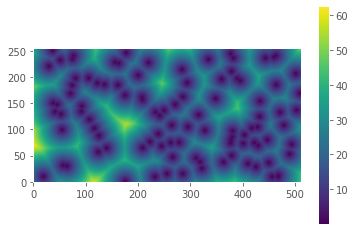

In [5]:
X=512
Y=256
distances, germes = constructions(X,Y,100)
calcul_python(distances, germes)
afficher_image(distances)

## Implémentation en numpy

La bibliothèque `numpy` permet de simplifier de nombreux algorithmes avec une notation matricielle.

In [6]:
def calcul_python_numpy(distances, germes):
    X,Y = np.mgrid[0:distances.shape[0], 0:distances.shape[1]]
    distances_totales = np.zeros((distances.shape[0], distances.shape[1], germes.shape[0] ) )
    for i in range(germes.shape[0]):         
        distances_totales[:,:,i] = ((germes[i,0]-X)**2 + (germes[i,1]-Y)**2)**(1/2)
    np.copyto(distances, distances_totales.min(axis=2))

Pour vérifier "visuellement" que l'implémentation Numpy est correcte on recalcule la même figure. Il est possible (et c'est bien plus rigoureux) de faire calculer l'erreur moyenne entre les deux implémentations.

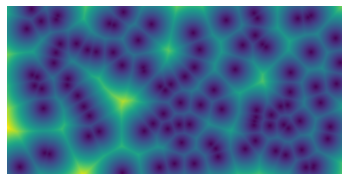

Erreur moyenne : 0.000000


In [8]:
reference_distances_python =  np.array(distances)
distances = np.zeros(distances.shape)
calcul_python_numpy(distances, germes)
plt.figure()
plt.imshow(distances.T, origin='lower')    
plt.grid(False)
plt.axis('off')
plt.show()

erreur = np.mean( np.abs( reference_distances_python - distances) ) 
print("Erreur moyenne : %f"%(erreur))

## Implémentation avec numba

A partir de l'implémentation Python naïve on ajoute un décorateur pour utiliser Numba.

In [9]:
@njit(cache=True)
def calcul_python_numba(distances, germes):
    for x in range(distances.shape[0]):
        for y in range(distances.shape[1]):
            d_min = distances.shape[0]*distances.shape[1]
            for i in range(germes.shape[0]):         
                d = ((germes[i,0]-x)**2 + (germes[i,1]-y)**2)**(1/2)
                if d<d_min:
                    d_min=d
            distances[x,y] = d_min

L'implémentation en `numpy` ne peux pas être reprise via Numba car la fonction `mgrid` n'est pas supporté par Numba.

```python
@njit(cache=True)
def calcul_python_numpy_numba(distances, germes):
    X,Y = np.mgrid[0:distances.shape[0], 0:distances.shape[1]]
    distances_totales = np.zeros((distances.shape[0], distances.shape[1], germes.shape[0] ) )
    for i in range(germes.shape[0]):         
        distances_totales[:,:,i] = ((germes[i,0]-X)**2 + (germes[i,1]-Y)**2)**(1/2)
    np.copyto(distances, distances_totales.min(axis=2))
```    

## Calcul des erreurs

Pour vérifier les résultats issus des différentes implémentations une fonction de calcul d'erreur simple est écrite.

In [10]:
def calcul_erreur(a,b):
    return snp.mean( np.abs( a - b) )

## Implémentation naïve en Cuda

Les différentes implémentations utilisant CUDA sont détaillées dans l'article.

In [11]:
@cuda.jit
def kernel_cuda(distances, germes):    
    x, y = cuda.grid(2)            
    n, m = distances.shape
    if 0 <= x < n and 0 <= y < m :
        d_min = n*m
        for _ in range(germes.shape[0]):                
            d = ((germes[_,0]-x)**2 + (germes[_,1]-y)**2)**(1/2)
            if d<d_min:
                d_min=d
        distances[x,y] = d_min

        
def calcul_python_numba_cuda(distances, germes):    
    threadsperblock = (32, 32)            
    blockspergrid_x = math.ceil(distances.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(distances.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)    
    kernel_cuda[blockspergrid, threadsperblock](distances, germes)

## Utilisation de la mémoire constante

In [12]:
@cuda.jit
def kernel_cuda_constant(distances):    
    x, y = cuda.grid(2)            
    n, m = distances.shape
    device_germes = cuda.const.array_like(germes)
    if 0 <= x < n and 0 <= y < m :    
        d_min = n*m
        for _ in range(device_germes.shape[0]):                
            d = ((device_germes[_,0]-x)**2 + (device_germes[_,1]-y)**2)**(1/2)
            if d<d_min:
                d_min=d
        distances[x,y] = d_min

        
def calcul_python_numba_cuda_constant(distances, germes, threads=32):    
    threadsperblock = (threads, threads) # Max 32*32           
    blockspergrid_x = math.ceil(distances.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(distances.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)        
    kernel_cuda_constant[blockspergrid, threadsperblock](distances)


## Mesure des temps de calculs

Les différentes implémentations sont comparées. Le nombre de germes est fixé à 1 pour 1000 pixels.

In [13]:
NB_REPET = 100
TAILLES = range(100,1501,50) # 6h13 de calculs !!!

temps_calculs = np.zeros((5,len(TAILLES)))

for idx in tqdm(range(len(TAILLES)) , desc="Taille de l'image" ):
    N = TAILLES[idx]
    G = int((N*N)*1e-4)    
    distances, germes = constructions(N,N,G)
    
    temps = timeit.timeit("calcul_python(distances, germes)", setup="from __main__ import calcul_python, distances, germes",  number=1)     
    temps_calculs[0,idx] = temps
    
    temps = timeit.timeit("calcul_python_numpy(distances, germes)", setup="from __main__ import calcul_python_numpy, distances, germes",  number=NB_REPET)     
    temps_calculs[1,idx] = temps/NB_REPET
        
    temps = timeit.timeit("calcul_python_numba(distances, germes)", setup="from __main__ import calcul_python_numba, distances, germes",  number=NB_REPET)         
    temps_calculs[2,idx] = temps/NB_REPET
    
    temps = timeit.timeit("calcul_python_numba_cuda(distances, germes)", setup="from __main__ import calcul_python_numba_cuda,germes,distances",  number=NB_REPET)          
    temps_calculs[3,idx] = temps/NB_REPET
    
    temps = timeit.timeit("calcul_python_numba_cuda_constant(distances, germes)", setup="from __main__ import calcul_python_numba_cuda_constant,germes,distances",  number=NB_REPET)          
    temps_calculs[4,idx] = temps/NB_REPET   

# Sauvegarde des résultats     
np.save("CalculsDistances", temps_calculs)

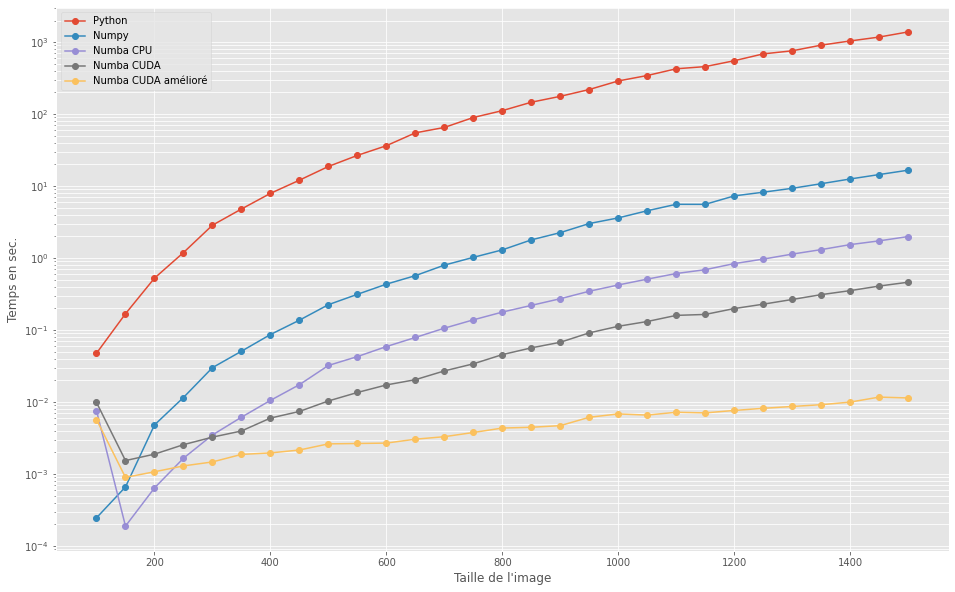

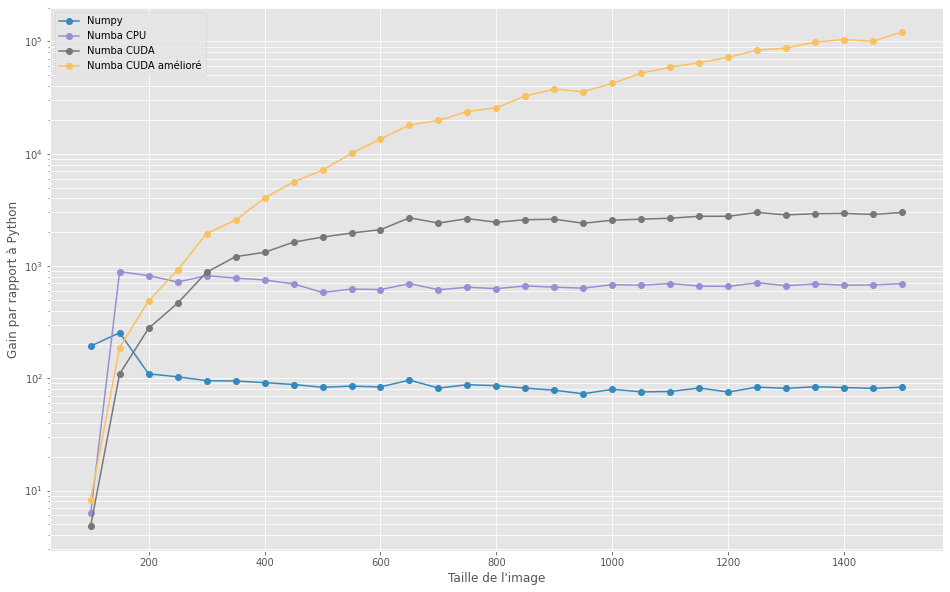

In [14]:
plt.figure(figsize=(16,10))    
plt.semilogy(TAILLES,temps_calculs[0,:], marker="o")
plt.semilogy(TAILLES,temps_calculs[1,:], marker="o")
plt.semilogy(TAILLES,temps_calculs[2,:], marker="o")
plt.semilogy(TAILLES,temps_calculs[3,:], marker="o")
plt.semilogy(TAILLES,temps_calculs[4,:], marker="o")

plt.legend(("Python", "Numpy" ,"Numba CPU","Numba CUDA","Numba CUDA amélioré"))
plt.xlabel("Taille de l'image")
plt.ylabel("Temps en sec.")
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.show()    

plt.figure(figsize=(16,10))    
plt.semilogy(TAILLES,temps_calculs[0,:]/temps_calculs[1,:], marker="o",c="C1")
plt.semilogy(TAILLES,temps_calculs[0,:]/temps_calculs[2,:], marker="o",c="C2")
plt.semilogy(TAILLES,temps_calculs[0,:]/temps_calculs[3,:], marker="o",c="C3")
plt.semilogy(TAILLES,temps_calculs[0,:]/temps_calculs[4,:], marker="o",c="C4")
plt.xlabel("Taille de l'image")
plt.ylabel("Gain par rapport à Python")
plt.legend(("Numpy" ,"Numba CPU","Numba CUDA","Numba CUDA amélioré"))
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.show()

## Configuration CUDA variable

Les gains en temps de calculs peuvent dépendre de la configuration de la grille de calcul.

In [18]:
nb_threads = range(1,33)
dims = range(100,1501,50)
temps = np.zeros((len(dims), len(nb_threads)))
temps_cpu = np.zeros(len(dims))
speedup = np.zeros((len(dims), len(nb_threads)))                      
NB_REPET = 100

for i in tqdm(range(len(dims)) , desc="Taille de l'image" ):
    N = dims[i]    
    G = int((N*N)*1e-4)
    distances, germes = constructions(N,N,G)    
    
    etemps = timeit.timeit("calcul_python_numba(distances, germes)", setup="from __main__ import calcul_python_numba, distances, germes",  number=10)         
    temps_cpu[i] = etemps/10     
    
    for j in range(len(nb_threads)):
        nb = nb_threads[j]
        etemps = timeit.timeit("calcul_python_numba_cuda_constant(distances, germes, nb)", setup="from __main__ import calcul_python_numba_cuda_constant,germes,distances,nb",  number=NB_REPET)          
        temps[i,j] = etemps/NB_REPET
        speedup[i,j] = temps_cpu[i] / temps[i,j]
        

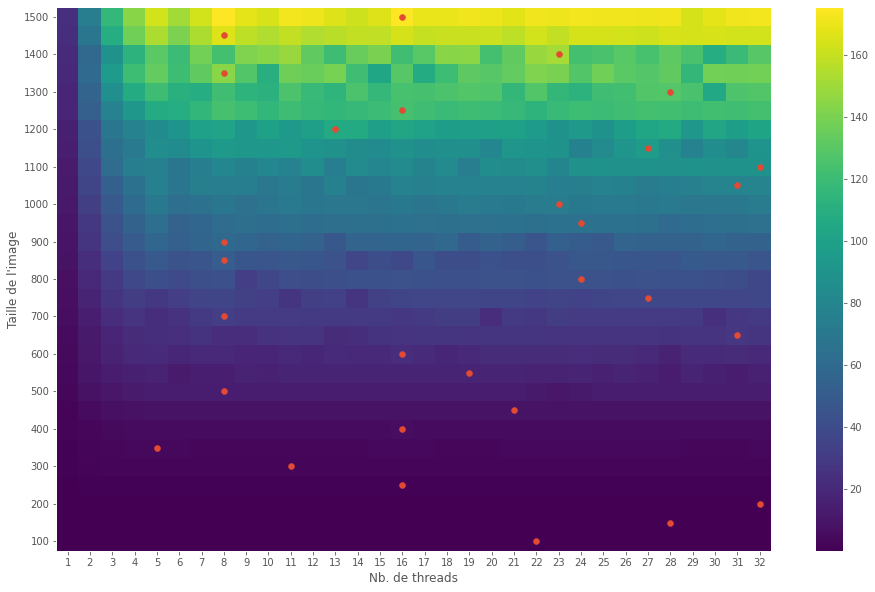

In [19]:
maxs = np.zeros(len(dims), np.int32)
for i in range(len(dims)):
    maxs[i] = nb_threads[speedup[i,:].argmax()]

xmin=1
xmax=33
dx=1
ymin=100
ymax=1501
dy=50

x2,y2 = np.meshgrid(np.arange(xmin,xmax+dx,dx)-dx/2.,np.arange(ymin,ymax+dy,dy)-dy/2.)

plt.figure(figsize=(16,10))
plt.pcolormesh(x2, y2, speedup)
clb = plt.colorbar()
plt.axis([x2.min(),x2.max(),y2.min(),y2.max()])
plt.xticks(np.arange(xmin,xmax,dx))
plt.yticks(np.arange(ymin,ymax,100))
plt.scatter(maxs, dims)
plt.xlabel("Nb. de threads")
plt.ylabel("Taille de l'image")
plt.show()

In [20]:
pos_max = np.unravel_index(speedup.argmax(), speedup.shape)
print(" Valeur %f dimension %d nb threads %d"% (speedup[pos_max], dims[pos_max[0]], nb_threads[pos_max[1]]))

 Valeur 175.458207 dimension 1500 nb threads 16
